# Suporte, distâncias e aprovações na linha temporal

```{epigraph}
There is little danger that any student, however idle or stupid, will fail to get some result; but there is great danger that he will be led astray, obsessed and overwhelmed by his results, even though it be by those which it is necessary that he should attain. Too often, moreover, he mistaketh the first resting-place for the goal, and taketh off his armour as if he were a victor ere the fight is well begun.

-- Aleister Crowley, «Liber O vel Manus et Sagittæ, sub figura VI»
```

In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from datetime import timedelta
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

In [2]:
## Get the data
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l13_ini_file = '../l13_ini.xml'
l13_ini_tree = ET.parse(l13_ini_file)
l14_ini_file = '../l14_ini.xml'
l14_ini_tree = ET.parse(l14_ini_file)
l15_ini_file="./l15.xml"
#l13_ini_file = './l13_ini
l15_ini_tree = ET.parse(l15_ini_file)
l15_ini_url="https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a6863793959566955794d45786c5a326c7a6247463064584a684c306c7561574e7059585270646d467a5746597565473173&fich=IniciativasXV.xml&Inline=true"
l15_ini_tree = ET.parse(urlopen(l15_ini_url))

In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [4]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [5]:
import collections
def ini_to_df_ini(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for ini in root.findall("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        for evento in ini.iter("pt_gov_ar_objectos_iniciativas_EventosOut"):
            for voting in evento.iter("pt_gov_ar_objectos_VotacaoOut"):
                votep = voting.find('./detalhe')
                if votep is not None:
                    init_dict = collections.OrderedDict()
                    counter +=1
                    init_dict["fase"] = evento.find("fase").text
                    for c in ini:
                        if c.tag == "iniAutorGruposParlamentares" or c.tag == "iniAutorDeputados":
                            if c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP') is not None:
                                init_dict[c.tag] = c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text
                            elif c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/GP').text == "Ninsc":
                                init_dict["iniAutorGruposParlamentares"] = c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/nome').text
                        else:
                            init_dict[c.tag] = c.text
                    counter +=1                 
                    init_dict['id'] = voting.find('id').text
                    ## Add the "I" for Type to mark this as coming from "Iniciativas"
                    init_dict['Tipo'] = "I"
                    for c in voting:
                        if c.tag == "detalhe":
                            for party, vote in parse_voting(c.text).items():
                                init_dict[party] = vote 
                        elif c.tag == "descricao":
                                init_dict[c.tag] = c.text
                        elif c.tag == "ausencias":
                                init_dict[c.tag] = c.find("string").text
                        else:
                                init_dict[c.tag] = c.text
                    init_list.append(init_dict)
            ## Provide progression feedback
        #print('.', end='')
    print(counter)
    return pd.DataFrame(init_list)
        


In [6]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show
from scipy.cluster.hierarchy import dendrogram

def political_distance_matrix(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')

    ## Create a square dataframe with the pairwise distances: the distance matrix
    distmat = pd.DataFrame(
        squareform(pwdist), # pass a symmetric distance matrix
        columns = vdf_votes_t.index,
        index = vdf_votes_t.index
    )
    return distmat
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

def political_pwdist(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')
    return pwdist
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
    
def political_distance_clustermap(vdf, plist, subtitle, size, pal):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Perform hierarchical linkage on the distance matrix using Ward's method.
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )
    fig = sns.clustermap(
        distmat,
        annot = True,
        cmap=sns.color_palette(pal),
        linewidth=1,
        #standard_scale=1,
        row_linkage=distmat_link,
        col_linkage=distmat_link,
        #fmt=".0%",
        figsize=size,
        
    ).fig.suptitle(subtitle,y=1)
    return fig
    #plt.show()

def political_linkage(vdf,plist):
    vdf = vdf[plist]
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True)
    return distmat_link

def political_dendogram(vdf, plist, subtitle):
    vdf = vdf[plist]

    fig = plt.figure(figsize=(8,5))
    dendrogram(political_linkage(vdf,plist), labels=vdf.columns)
    plt.title(subtitle)
    plt.show()
    
def political_heatmap(vdf,plist,title):
    vdf_hmn = vdf[plist].replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)
    voting_palette = ["#FB6962","#FCFC99","#79DE79"]
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(vdf_hmn,
                square=False,
                yticklabels = False,
                cbar=False,
                cmap=sns.color_palette(voting_palette),
               )
    plt.title(title)
    plt.show()

In [7]:
l13_parties = ['BE', 'PCP' ,'PEV', 'PS', 'PAN', 'PSD','CDS-PP']
l14_parties = ['BE', 'PCP', 'L', 'PS', 'PAN','PSD','IL', 'CH']
l15_parties = ['BE', 'PCP', 'L', 'PS', 'PAN','PSD','IL', 'CH']
l14_parties = ['BE', 'PCP', 'PEV', 'L', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']


In [8]:
l13_ini_df = ini_to_df(l13_ini_tree)
l14_ini_df = ini_to_df(l14_ini_tree)
l15_ini_df = ini_to_df(l15_ini_tree)


In [9]:
## Copy Livre voting record to new aggregate columns...
l14_ini_df["L/JKM"] = l14_ini_df["L"]
## ... and fill the NAs with JKM voting record.
l14_ini_df["L/JKM"] = l14_ini_df["L/JKM"].fillna(l14_ini_df["Joacine Katar Moreira (Ninsc)"])
l14_ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]]
## Remove next to keep JKM separate
l14_ini_df["L"] = l14_ini_df["L/JKM"]

## Copy PAN voting record to new aggregate columns...
l14_ini_df["PAN/CR"] = l14_ini_df["PAN"]
## ... and update/replace with CR voting where it exists
l14_ini_df["PAN/CR"].update(l14_ini_df["Cristina Rodrigues (Ninsc)"])
l14_ini_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]]

l14_votes = l14_ini_df
l14_votes['data']= pd.to_datetime(l14_votes['data'])
l14_votes['ano'] = pd.DatetimeIndex(l14_votes['data']).year
l14_votes['leg'] = 14
l14_votes_hm=l14_votes[l14_parties]
l14_votes_nu = l14_votes[l14_votes["unanime"] != "unanime"]
l14_votes_nu_hm=l14_votes_nu[l14_parties]
l14_min_date=min(l14_votes["data"])


l15_votes = l15_ini_df
l15_votes['data']= pd.to_datetime(l15_votes['data'])
l15_votes['ano'] = pd.DatetimeIndex(l15_votes['data']).year
l15_votes['leg'] = 15
l15_votes_hm=l15_votes[l15_parties]
l15_votes_nu = l15_votes[l15_votes["unanime"] != "unanime"]
l15_votes_nu_hm=l15_votes_nu[l15_parties]
l15_min_date=min(l15_votes["data"])

In [10]:
l13_votes = l13_ini_df
l13_votes['data']= pd.to_datetime(l13_votes['data'])
l13_votes['ano'] = pd.DatetimeIndex(l13_votes['data']).year
l13_votes['leg'] = 13
l13_min_date=min(l13_votes["data"])
l13_max_date=l14_min_date - timedelta(1)
l13_votes = l13_votes[(l13_votes['data'] <= l13_max_date)]
l13_votes_hm=l13_votes[l13_parties]
l13_votes_nu = l13_votes[l13_votes["unanime"] != "unanime"]
l13_votes_nu_hm=l13_votes_nu[l13_parties]


## Proximidades e distância ao longo do tempo


As análises feitas até à data têm focado a proximidade e distância - em várias dimensões diferentes - dos vários partidos, e se é verdade que a utilização das visualizações originais (_clustermaps_, MDSs, dendogramas, etc) é feita de forma a permitir a comparação de vários anos e legislatura, isso é conseguido através da comparação dos gráficos que representam a situação em determinado momento.

Um pedido comum é visualizar como evoluem as proximidades/aprovações/distâncias ao longo do tempo, de uma forma que coloque a dimensão temporal em primeiro plano: esta actualização adiciona novas formas de apresentar os dados que vão nesse sentido.

Uma das vantagens dos _clustermaps_ e gráficos em 2D com a posição relativa dos partidos é a forma como, de forma muito imediata, permitem uma leitura dos dados através de uma única imagem: um único _clustermap_ permite identificar a proximidade e de que forma se agrupam os partidos para todo o período em análise. Ao promover a dimensão temporal torna-se difícil condensar os dados desta forma, pois mostrar todas as distâncias entre todos os partidos numa linha do tempo seria de tal forma confuso ao ponto de ser incompreensível. Optámos por separar os partidos (de forma semelhante ao que já foi feito para apresentar dados relativos às aprovações de propostas) e mostrar uma linha temporal como eixo principal.

Estes dados são complementares aos já existentes: pode-se imaginar que a posição de todos os partidos em determinada altura, tal como apresentada nesta actualização de forma separada, corresponde ao _clustermap_ e gráfico de distância 2D correspondente.


In [11]:
l14a = ini_to_df_ini(l14_ini_tree)
l15a = ini_to_df_ini(l15_ini_tree)


7492
2638


In [12]:
l15af = l15a[l15a["fase"] == "Votação na generalidade"]
l15af["GP"] = l15af["iniAutorGruposParlamentares"]
l15af = l15af[l15af["GP"].notna()]


l14af = l14a[l14a["fase"] == "Votação na generalidade"]
l14af["iniAutorGruposParlamentares"]  = l14af["iniAutorGruposParlamentares"].replace("JOACINE KATAR MOREIRA", "L")
l14af["GP"] = l14af["iniAutorGruposParlamentares"]
l14af = l14af[l14af["GP"].notna()]



/tmp/ipykernel_240207/1742211003.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_240207/1742211003.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_240207/1742211003.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
mycol  = ['GP', 'data','BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH' ]
all_subs_hm = pd.concat([l14af, l15af], axis=0)

df=all_subs_hm
submissions_ini = df[mycol]
submissions_ini['data'] = pd.to_datetime(submissions_ini['data'])
submissions_ini.sort_values(by='data', inplace = True)
min_date=min(submissions_ini["data"])
max_date=max(submissions_ini["data"])
#submissions_ini
#max_date 


/tmp/ipykernel_240207/2854411193.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/frmuno/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Âmbito e pressupostos

Optámos por incluir os dados da XIV e XV legislatura (até à data), de forma a permitir uma leitura que inclua mais anos e permita, eventualmente, uma análise mais aprofundada. Esta opção acarreta alguns compromissos, o mais importante o de apenas incluir os partidos que estão presentes em ambas as legislaturas. Isto exclui o CDS-PP e o PEV.
```{margin}
Um próximo passo poderá ser a criação de análises por legislatura.
```
No caso dos deputados únicos, os votos do Livre incluem os da deputada Joacine Kata Moreira.

São contabilizados apenas os votos

```{margin} Estatísticas base
Os dados essenciais dos ficheiro XML importado são os seguintes:
```

In [14]:
from datetime import datetime
from IPython.display import display, Markdown, Latex


display(Markdown("*Total de votações:* {}".format(submissions_ini.shape[0])))
display(Markdown("*Data limite inferior:* {}".format(datetime.date(min_date))))
display(Markdown("*Data limite superior:* {}".format(datetime.date(max_date))))


*Total de votações:* 1905

*Data limite inferior:* 2019-11-15

*Data limite superior:* 2023-04-28

## Apoios a propostas

Começamos pela análise que leva em conta os autores das propostas, em moldes semelhantes à [análise já feita](https://fsmunoz.github.io/parlamento/html/l14-autores.html), mas focando na evolução ao longo do tempo para cada partido.

Como neste caso sabemos o autor da proposta, podemos utilizar uma valorização dos votos que assenta não na distância, mas na posição em relação à proposta:

* A Favor: +1
* Contra: -1
* Abstenção/Ausência: 0

Ao irmos somando os votos ao longo do tempo, a cada momento o valor de "suporte" representa o acumulado de todos os votos até à data, indo subindo ou descendo conforme os padrões de votação.

Intuitivamente podemos imagine os seguintes cenários:

* Um partido que apoie _sempre_ as propostas de outro irá ter uma recta em sentido ascendente, pois a cada votação o valor acumulado é +1 que o anterior.
* Um partido que vote _sempre contra_ as propostas de outro irá ter uma recta em sentido descendente, pois a cada votaçãi o valor acumulado é -1 que o anterior.
* Um partido que _se abstenha sempre_ das propostas de outro ir«a ter uma recta horizontal, pois o valor irá permanecer em 0 desde a origem.

Mais genericamente, em termos de tendências:

* Rectas sem grandes oscilações em termos de direcção indicam, tendencialmente, um comportamento uniforme ao longo do tempo.
* Zigue-zagues e outras oscilações de direcção indicam uma variação de comportamento ao longo do tempo.

O eixo horizontal representa as datas das votações, e o vertical o valor acumulado conforme a quantificação descrita acima.

In [15]:
#submissions_ini_hm = submissions_ini[submissions_ini != "Ausência"]
submissions_ini_hm = submissions_ini.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0])
#df = df[df.line_race != 0]
#submissions_ini_hm["resultado"].unique()

In [16]:

submissions_ini_hm =submissions_ini_hm.set_index("data")


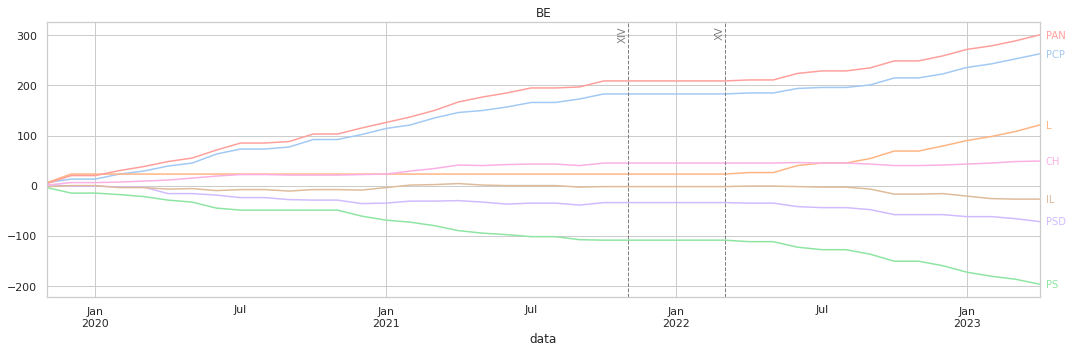

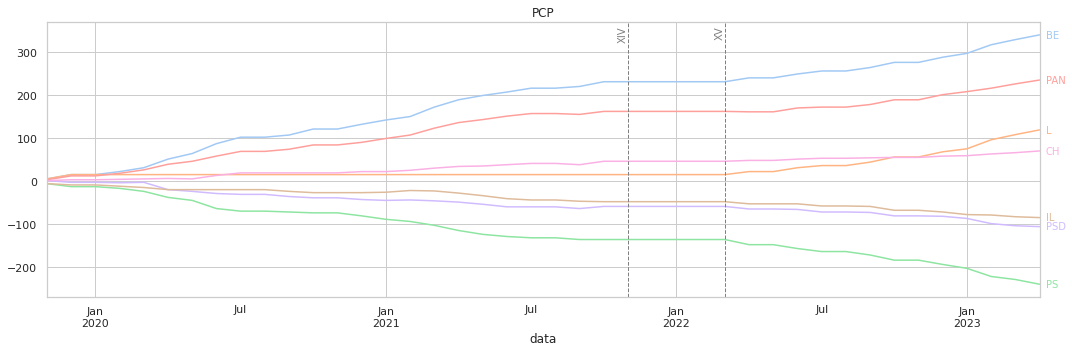

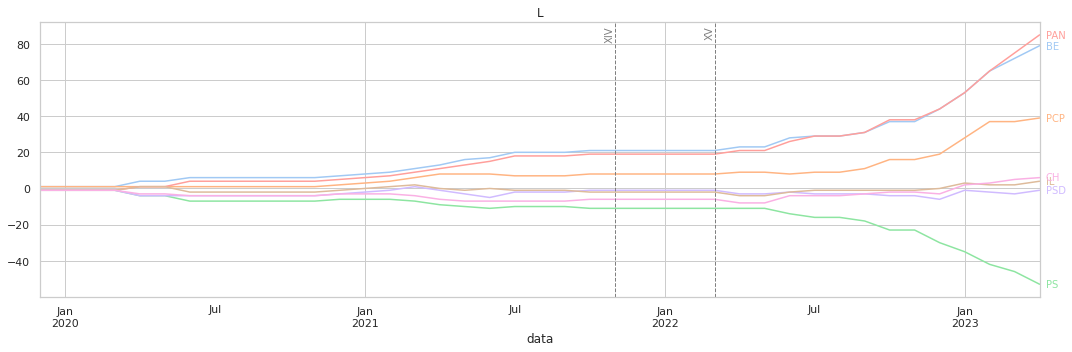

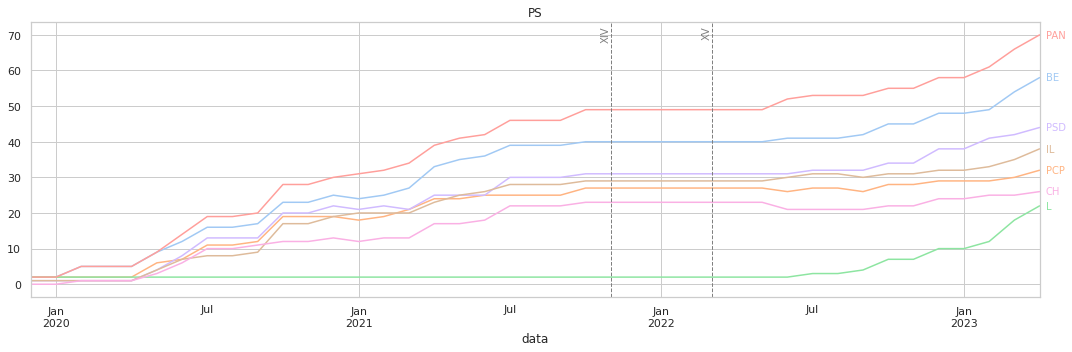

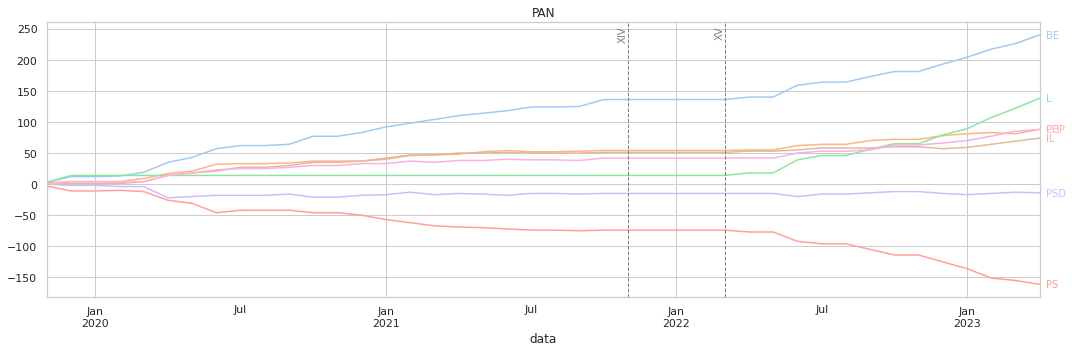

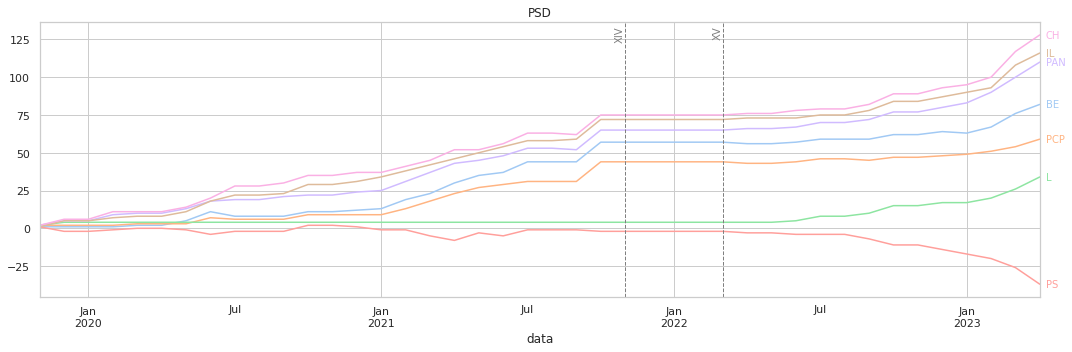

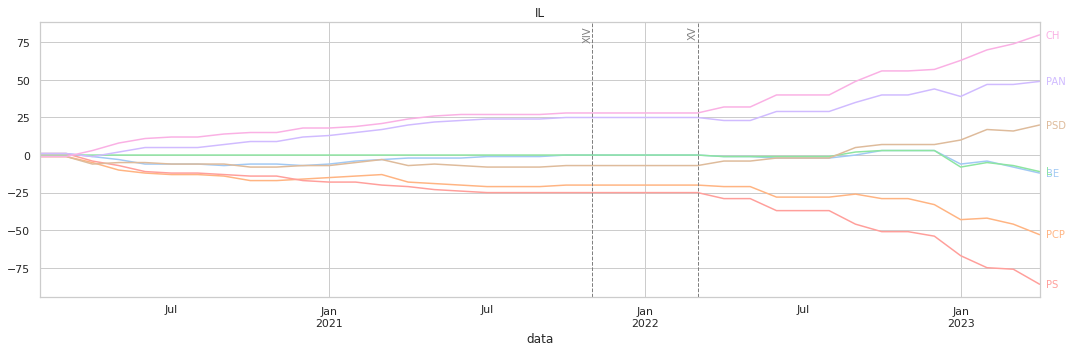

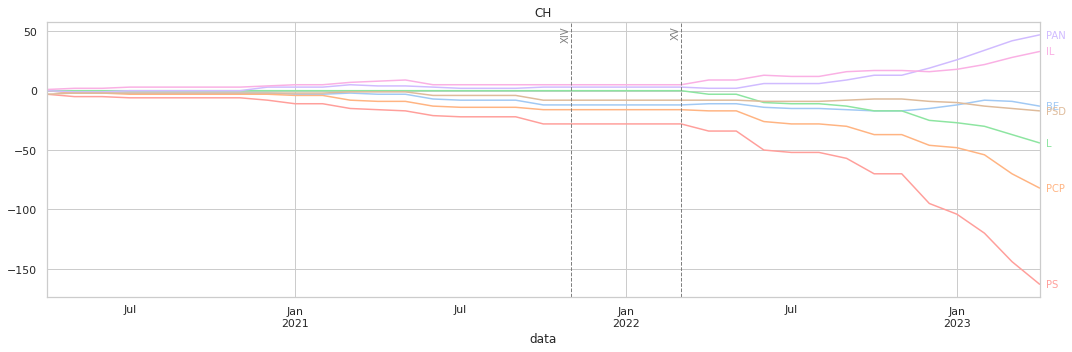

In [17]:
sns.set_style("whitegrid")

parties = ['BE', 'PCP', 'L','PS', 'PAN','PSD','IL','CH' ]
gpsubs = submissions_ini_hm
for party in parties:
    subp = gpsubs[gpsubs['GP'] == party]
    subp = subp[parties]
    #fig = plt.figure()
    subp = subp.drop(party, axis=1)
    ax = subp.resample("1M").sum().cumsum().plot(kind="line", title=party, figsize=(15,5))
    
    for line, name in zip(ax.lines, subp.columns):
        y = line.get_ydata()[-1]
        ax.annotate(line.get_label(), xy=(1,y), xytext=(6,0), color=line.get_color(), 
            xycoords = ax.get_yaxis_transform(), textcoords="offset points",
            size=10, va="center")

    #plt.legend(loc='lower left')
    plt.axvline(pd.to_datetime('2021-11-26'), color='grey', linestyle='--', lw=1)
    plt.axvline(pd.to_datetime('2022-03-29'), color='grey', linestyle='--', lw=1)
    ax.text(pd.to_datetime('2022-03-29'), 0.99, 'XV', color='grey', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
    ax.text(pd.to_datetime('2021-11-26'), 0.99, 'XIV', color='grey', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
    ax.get_legend().remove()
    plt.tight_layout()

    #plt.show()

A maior parte dos gráficos mostra-nos uma tendência constante de votações, sem grandes variações abruptas. Os resultados finais têm, de uma forma imediata, relação com os _clustermaps_ anterire

## Distância ao longo do tempo


Medir a distância é diferente de medir o apoio a propostas; relembrando:

1. As distâncias são obtidas pela concordância ou diferença no sentido de voto entre os pares de partidos, independentemente da origem da matéria em votação.
2. São analisadas todas as votações, sendo o universo maior que a análisr anterior (que contempla apenas as votações na generalidade).

Se na análise anterior podiamos usar 1/0/-1 para medir o grau de apoio, na distância o que medimos é a diferença entre posições ao longo do tempo:

* Se dois partidos votam da mesma forma, a distância é 0.
* Se dois partidos votam de forma diferente, mas não diametralmente oposta, a distância é 1 (por exemplo, se um partido vota contra e o outro se abstem).
* Se dois partidos votam de forma diametralmente oposta, a distância é 2 (por exemplo, um vota contra e outra vota a favor).

Esta é exactamente a mesma abordagem usada para as análises anterior, para as quais remetemos para detalhes adicionais.

Ao medirmos a distância, o gráfico irá ter uma forma diferente: aqui, um partido que vote _sempre_ da mesma forma que o partido em análise irá ter uma linha horizontal, por a distância será sempre 0. Não existem valores negativos, pois a distância mínima entre dois partidos é 0: quanto mais "cresce" a linha mais distante o partido está.

Acrescentámos duas linhas verticais que marcam o fim da XIV legislatura, e o início da XV, para de forma mais clara se poder observar eventuais mudanças na dinâmica das votações.


In [18]:
l14_votes_hm["data"]=l14_votes["data"]
l15_votes_hm["data"]=l15_votes["data"]

all_votes_hm = pd.concat([l14_votes_hm, l15_votes_hm], axis=0)
all_votes_hm["data"]
#l14af["iniAutorGruposParlamentares"]  = l14af["iniAutorGruposParlamentares"].replace("JOACINE KATAR MOREIRA", "L")
all_votes_hm

/tmp/ipykernel_240207/1308423332.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_240207/1308423332.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,BE,PCP,PEV,L,PS,PAN,PAN/CR,PSD,IL,CDS-PP,CH,data
0,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
1,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
2,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
3,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,2020-06-26
4,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,2020-07-23
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,Contra,Contra,NaN,Contra,A Favor,Abstenção,NaN,A Favor,A Favor,NaN,A Favor,2023-03-17
1315,Abstenção,Abstenção,NaN,A Favor,A Favor,Abstenção,NaN,A Favor,A Favor,NaN,A Favor,2022-10-07
1316,Contra,Contra,NaN,A Favor,A Favor,A Favor,NaN,A Favor,A Favor,NaN,A Favor,2022-09-16
1317,Contra,Contra,NaN,A Favor,A Favor,A Favor,NaN,A Favor,A Favor,NaN,A Favor,2022-09-16


In [19]:
l13_min_date=min(l13_votes["data"])
l13_max_date=l14_min_date - timedelta(1)
l13_min_date
l13_max_date

Timestamp('2019-10-24 00:00:00')

In [20]:

#all_votes_hm = all_votes_hm[all_votes_hm != "Ausência"]
all_votes_hmn = all_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0])
all_votes_hmn['data'] = pd.to_datetime(all_votes_hmn['data'])
all_votes_hmn.sort_values(by='data', inplace = True) 
all_ts =all_votes_hmn.set_index("data")
all_parties = ['BE', 'PCP', 'L', 'PS', 'PAN', 'PSD', 'IL', 'CH']

#all_votes_hmn['data']

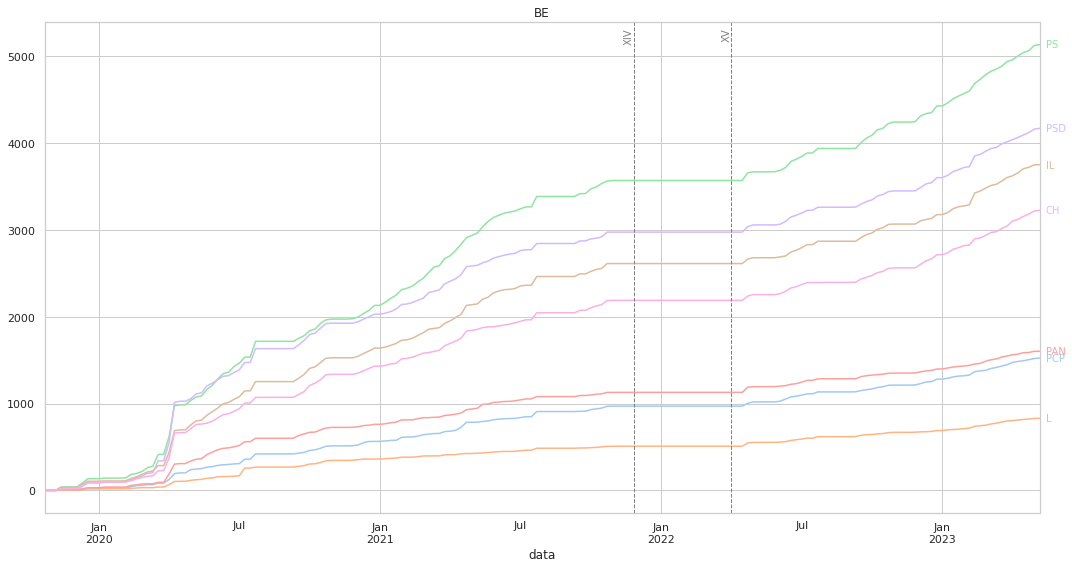

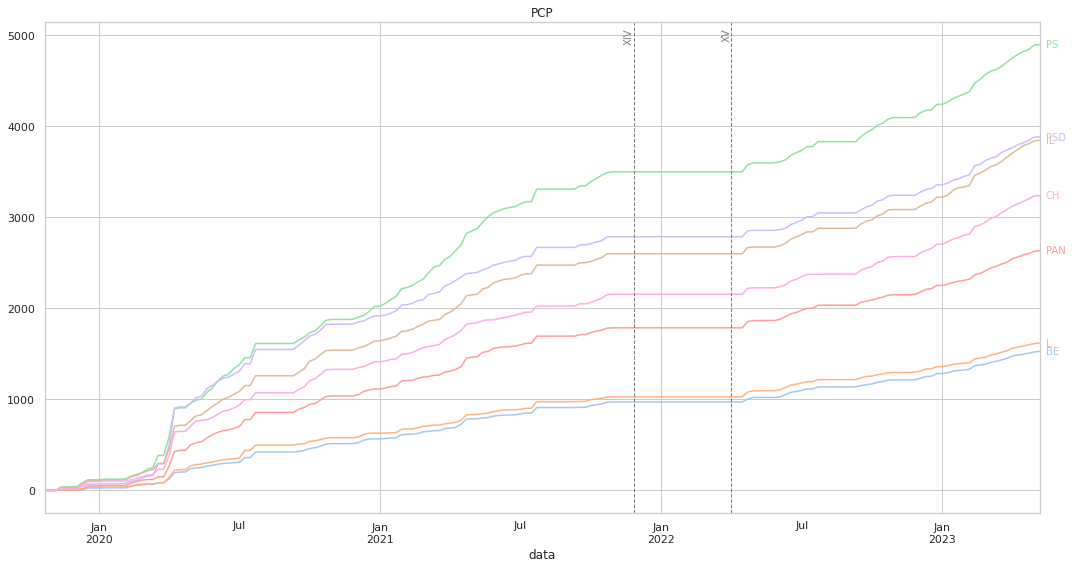

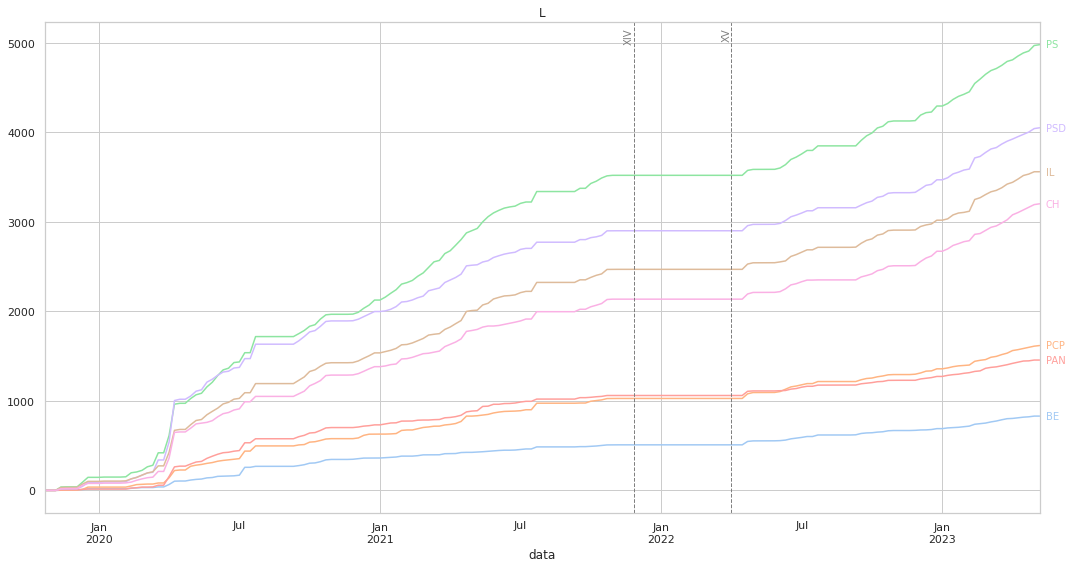

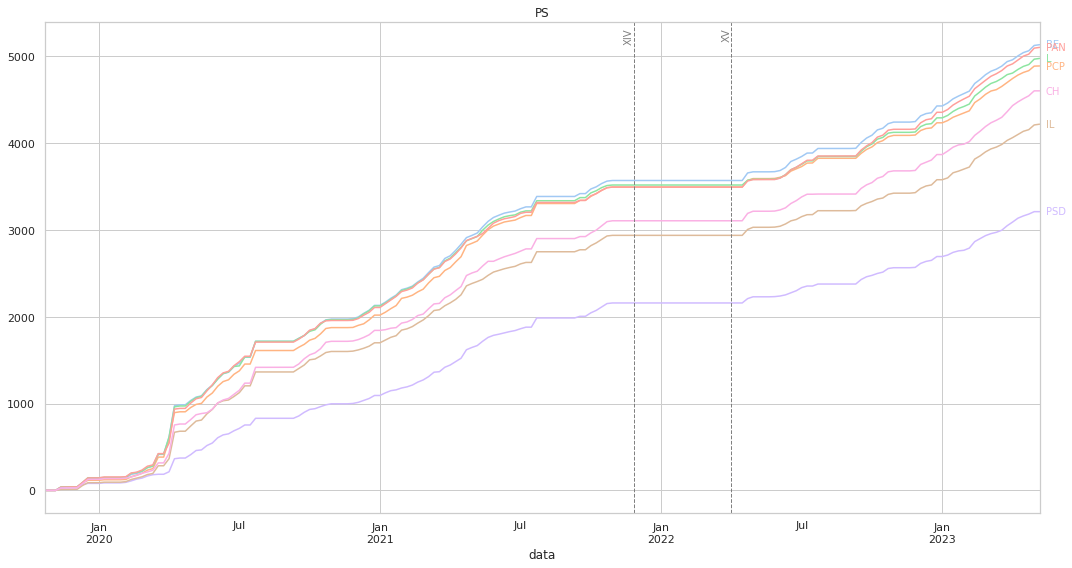

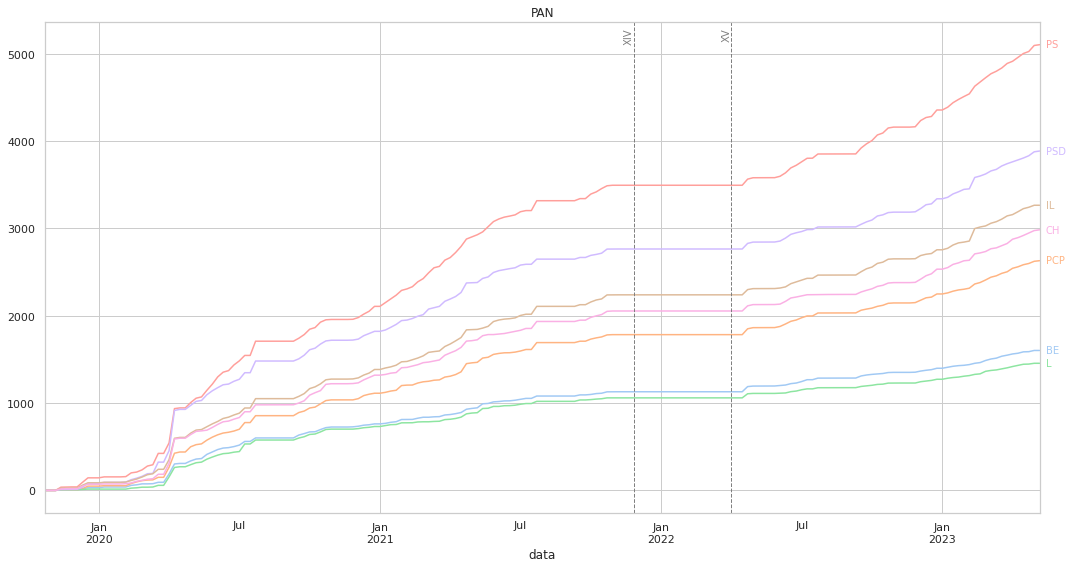

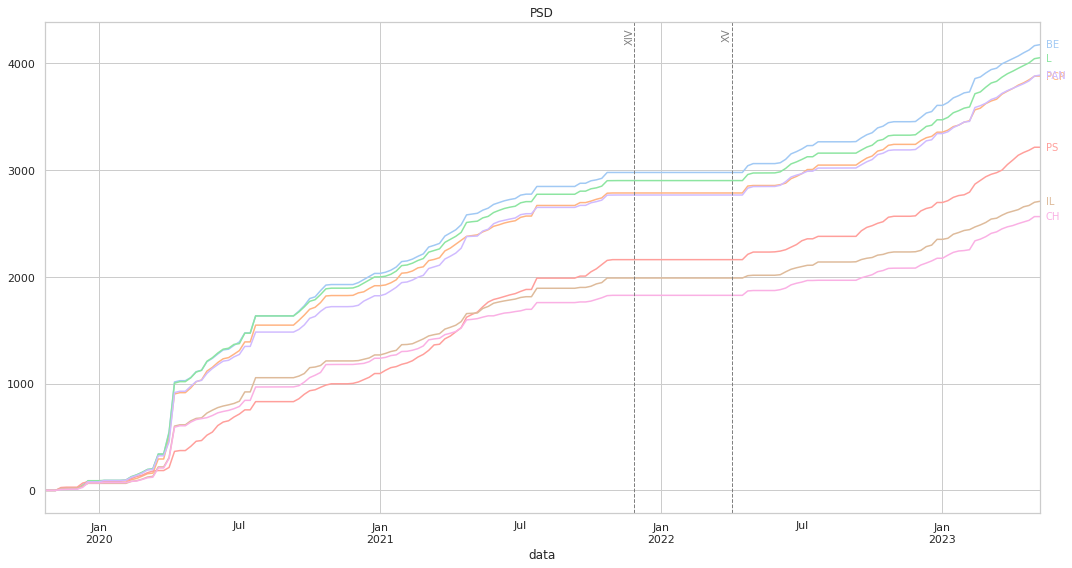

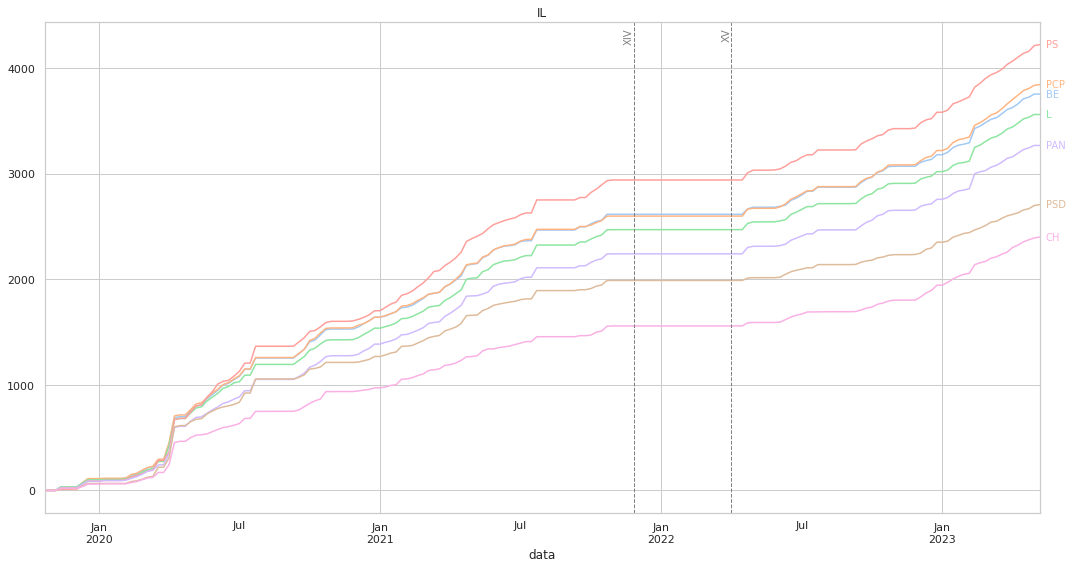

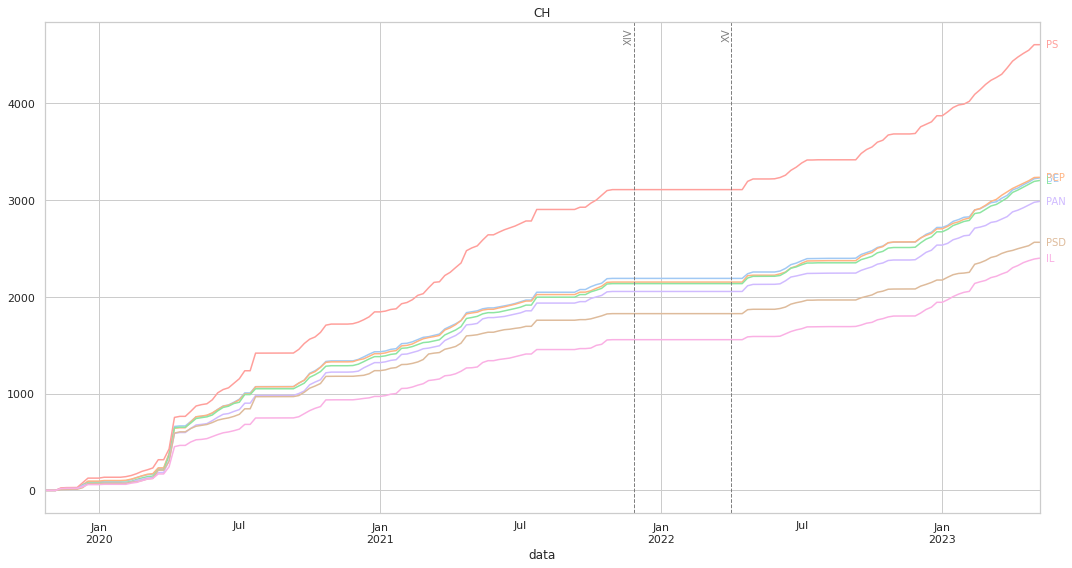

In [21]:
distances = {}

for party in all_parties:
    party_dist_df = all_ts
    party_dist_df = party_dist_df
    for dist_party in all_parties:
        party_dist_df[str("dist_" + dist_party)] = abs(party_dist_df[party]-party_dist_df[dist_party])
    distances[party] = party_dist_df.copy(deep=True)
    party_dist_df = party_dist_df.drop(str("dist_" + party), axis=1)

    #fig = plt.figure()
    ax = party_dist_df.filter(regex=("dist_.*")).resample("1W").sum().cumsum().plot(kind="line", title=party, figsize=(15,8))
    #ax = party_dist_df.filter(regex=("dist_.*")).cumsum().plot(kind="line", title=party, figsize=(15,8))
    
    for line, name in zip(ax.lines, party_dist_df.columns):
        y = line.get_ydata()[-1]
        ax.annotate(line.get_label().replace("dist_",""), xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=10, va="center")
    #plt.legend(loc='upper left'
    ax.get_legend().remove()
    plt.axvline(pd.to_datetime('2021-11-26'), color='grey', linestyle='--', lw=1)
    plt.axvline(pd.to_datetime('2022-03-29'), color='grey', linestyle='--', lw=1)
    ax.text(pd.to_datetime('2022-03-29'), 0.99, 'XV', color='grey', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
    ax.text(pd.to_datetime('2021-11-26'), 0.99, 'XIV', color='grey', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
    plt.tight_layout()

    #plt.show()
    #display(party_dist_df)

In [22]:
all_votes_hm

,BE,PCP,PEV,L,PS,PAN,PAN/CR,PSD,IL,CDS-PP,CH,data
0,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
1,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
2,Contra,Contra,Contra,Contra,A Favor,Contra,Contra,A Favor,Abstenção,Contra,Contra,2020-07-23
3,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,2020-06-26
4,A Favor,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor,2020-07-23
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,Contra,Contra,NaN,Contra,A Favor,Abstenção,NaN,A Favor,A Favor,NaN,A Favor,2023-03-17
1315,Abstenção,Abstenção,NaN,A Favor,A Favor,Abstenção,NaN,A Favor,A Favor,NaN,A Favor,2022-10-07
1316,Contra,Contra,NaN,A Favor,A Favor,A Favor,NaN,A Favor,A Favor,NaN,A Favor,2022-09-16
1317,Contra,Contra,NaN,A Favor,A Favor,A Favor,NaN,A Favor,A Favor,NaN,A Favor,2022-09-16


Mais uma vez, os valores "finais" estão alinhados com o que pode ser visto nos _clustermaps_.

## Aprovações

Por último, foquemos as taxas de aprovação ao longo do tempo. Aqui o que é medido é o sucesso das propostas de cada partido, o que depende do apoio parlamentar que tenham.

Note-se que a quantidade de propostas de cada partido pode ser substancialmente diferente (valor indicado no eixo vertical).

In [23]:
mycol  = ['GP', 'data','BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH','resultado' ]
all_subs_hm = pd.concat([l14af, l15af], axis=0)

df=all_subs_hm
submissions_ini = df[mycol]
submissions_ini['data'] = pd.to_datetime(submissions_ini['data'])
#submissions_ini.sort_values(by='data', inplace = True) 
submissions_ini = submissions_ini.set_index("data")
submissions_ini

/tmp/ipykernel_240207/3585155328.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,GP,BE,PCP,L,PS,PAN,PSD,IL,CH,resultado
data,,,,,,,,,,
2020-10-09,PSD,A Favor,Contra,NaN,A Favor,A Favor,A Favor,A Favor,Ausência,Aprovado
2020-09-25,BE,A Favor,A Favor,NaN,Contra,Abstenção,Contra,Contra,A Favor,Rejeitado
2020-09-25,PCP,A Favor,A Favor,NaN,A Favor,A Favor,Contra,Abstenção,Abstenção,Aprovado
2020-09-25,CRISTINA RODRIGUES,A Favor,A Favor,NaN,Contra,Abstenção,Contra,Contra,A Favor,Rejeitado
2020-09-18,BE,A Favor,A Favor,NaN,Contra,A Favor,Contra,Contra,Abstenção,Rejeitado
...,...,...,...,...,...,...,...,...,...,...
2022-07-08,BE,A Favor,Contra,A Favor,Contra,A Favor,Abstenção,Abstenção,Abstenção,Rejeitado
2022-06-30,PAN,A Favor,A Favor,A Favor,Abstenção,A Favor,A Favor,A Favor,A Favor,Aprovado
2022-04-22,PCP,A Favor,A Favor,A Favor,Contra,Contra,Contra,Contra,A Favor,Rejeitado


In [26]:
submissions_ini = submissions_ini[submissions_ini["resultado"].isin(["Aprovado", "Rejeitado"])]

submissions_ini_hm = submissions_ini.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
#submissions_ini_hm = pd.melt(submissions_ini_hm,id_vars=value_vars=["resultado"])

                                                                              
#submissions_ini_hm = submissions_ini.replace(["Aprovado", "Rejeitado"], [1,0])
#submissions_ini_hm =submissions_ini_hm.set_index("data")
submissions_ini_hm 

,GP,BE,PCP,L,PS,PAN,PSD,IL,CH,resultado
data,,,,,,,,,,
2020-10-09,PSD,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,0.0,Aprovado
2020-09-25,BE,1.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,Rejeitado
2020-09-25,PCP,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,0.0,Aprovado
2020-09-25,CRISTINA RODRIGUES,1.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,Rejeitado
2020-09-18,BE,1.0,1.0,0.0,-1.0,1.0,-1.0,-1.0,0.0,Rejeitado
...,...,...,...,...,...,...,...,...,...,...
2022-07-08,BE,1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,Rejeitado
2022-06-30,PAN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,Aprovado
2022-04-22,PCP,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,Rejeitado


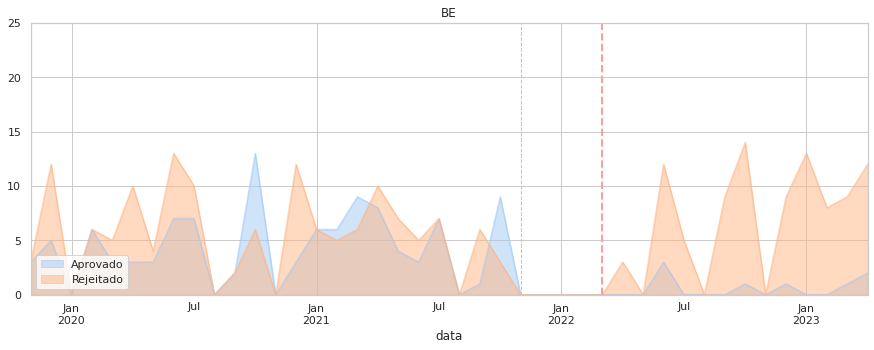

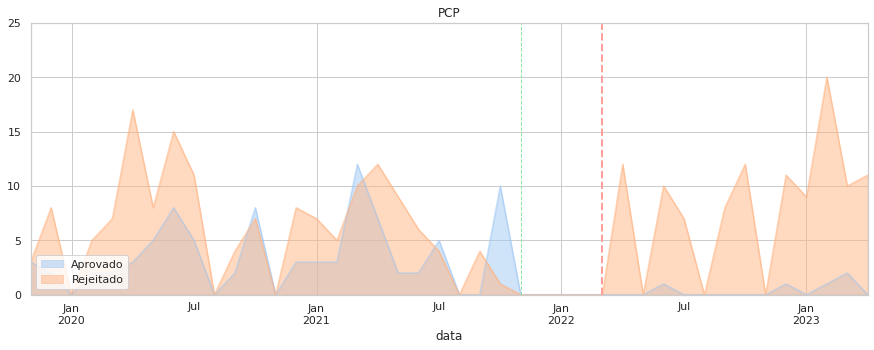

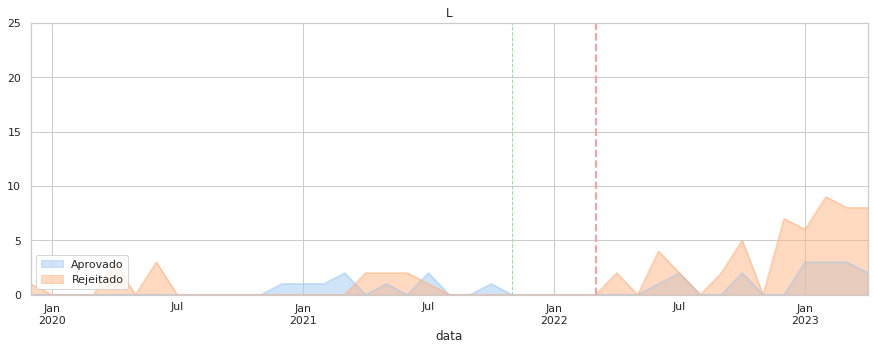

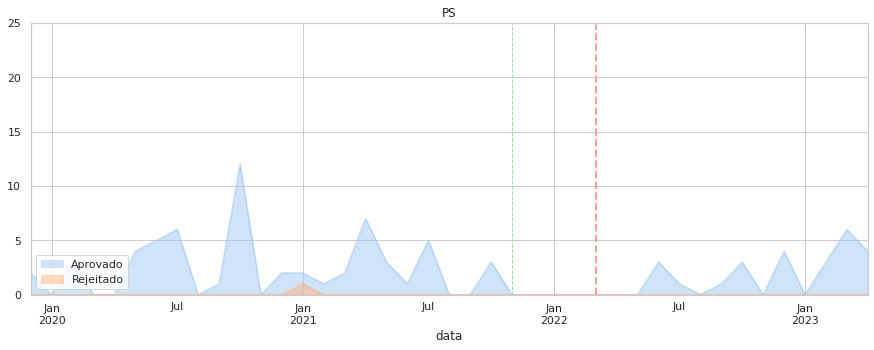

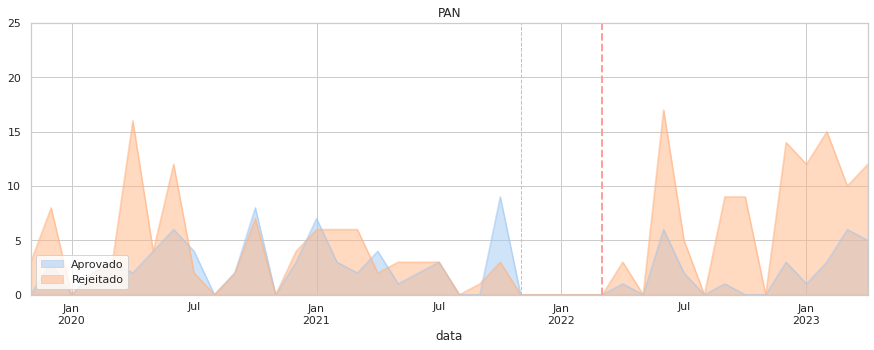

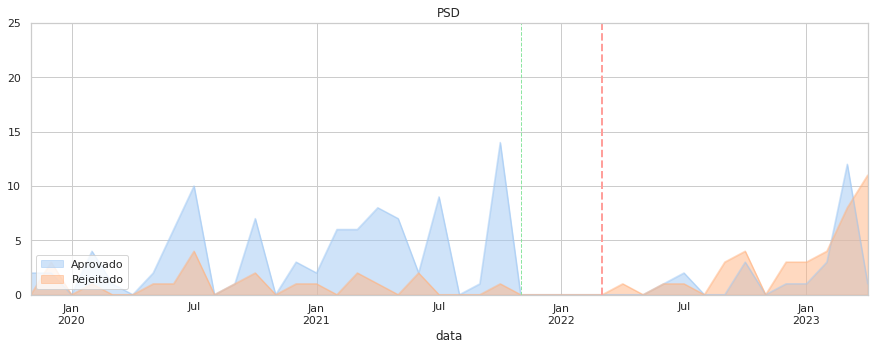

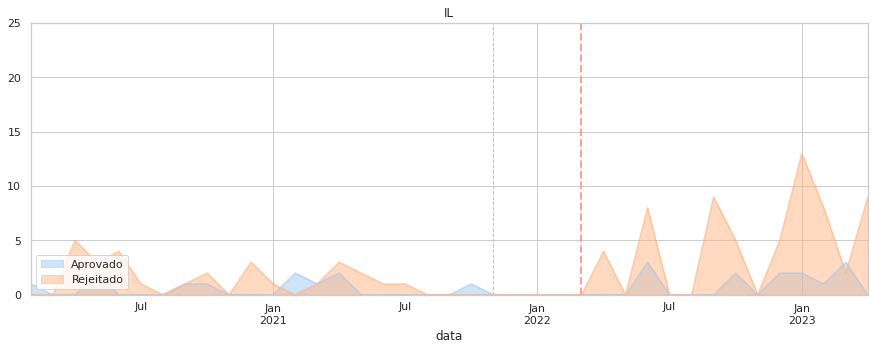

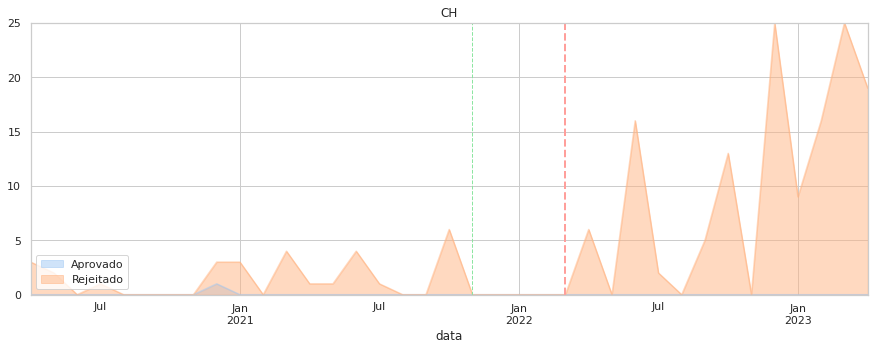

In [27]:
parties = ['BE', 'PCP', 'L', 'PS', 'PAN','PSD','IL','CH' ]
gpsubs= submissions_ini_hm.copy(deep=True)

#gpsubs = submissions_ini_hm
for party in parties:
    subp = gpsubs[gpsubs['GP'] == party]
    result_dummies = pd.get_dummies(subp["resultado"])
    result_dummies.columns = ['Aprovado','Rejeitado']
    subp = pd.concat([subp, result_dummies], axis=1)
    subp = subp[["Aprovado", "Rejeitado"]]
    ax = subp.resample("1M").sum().plot(kind="area", stacked=False, title=party, figsize=(15,5))
    ax.set_ylim([0, 25])
    plt.legend(loc='lower left')
    plt.axvline(pd.to_datetime('2021-11-26'), color='g', linestyle='--', lw=1)
    plt.axvline(pd.to_datetime('2022-03-29'), color='r', linestyle='--', lw=2)
    plt.show()
    #display(subp.resample("1M").sum().cumsum())